In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray
import pandas as pd
from scipy.interpolate import interp1d
import os
import sys
import glob

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
module_path = os.path.join(os.environ['HOME'],'tools','a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind, covariance, power_spectral_density, theta

In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT coupling comparison: Data analysis (template)

Simulation name and directory, and name of virtual towers

In [6]:
simname = 'internal_bcc_wrf_sowfa' # This is output prefix
dpath = '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/'
tower_filter = 'probe[0-9]'

In [7]:
tpathlist = glob.glob(os.path.join(dpath,tower_filter))
tpathlist.sort()
tpathlist

['/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe1',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe2',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe3',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe4',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe5',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe6',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe7',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe8',
 '/scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe9']

In [8]:
output_tower0_10min   = os.path.join('./data',simname+'_tower0_10min.csv')
output_tower0_spectra = os.path.join('./data',simname+'_tower0_spectra.csv')
output_all_10min      = os.path.join('./data',simname+'_10min.csv')
output_all_spectra    = os.path.join('./data',simname+'_spectra.csv')

Heights and times at which spectra are computed

In [9]:
spectra_heights = [10., 32., 80., 120.]
spectra_times = pd.date_range(start='2013-11-08 12:00:00',end='2013-11-09 11:00:00',freq='1h')

# Part 1: Load, process and plot single virtual tower

## 1. Load virtual tower data

### 1a. Code-specific data loader

<font size=4><font color="red">**Define code-specific reader that returns a standardized pandas dataframe:**</font></font>

- multi-index dataframe with index levels `datetime` and `height`
- time axis is a `pd.DatetimeIndex`
- standard column names `u`, `v`, `w`, and `theta`
- standard SI units of [m], [m/s], and [K]

For example: use [NWTC/datatools/SOWFA6/postProcessing](https://github.com/NWTC/datatools/tree/master/SOWFA6/postProcessing) for reading in SOWFA output data

In [10]:
# manually add NWTC/datatools repo to PYTHONPATH
module_path = os.path.join(os.environ['HOME'],'tools')
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
from datatools.SOWFA6.postProcessing.probes import Probe

In [12]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!! SOWFA specific data reader, implement your own data reader as needed !!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def reader(tpath):
    # Read in virtual tower data and convert to pandas DataFrame
    df = Probe(tpath,verbose=False).to_pandas()
    
    # Convert time in seconds to datetime
    df.reset_index(inplace=True)
    df['t'] = pd.to_timedelta(df['t'],unit='s') + pd.to_datetime('2013-11-08 00:00')
    
    # Rename columns
    df.columns = ['datetime', 'height', 'u', 'v', 'w', 'theta']
    
    # Set multi-index with levels datetime and height
    df.set_index(['datetime','height'],inplace=True)
    return df

### 1b. Load data

In [13]:
%time df = reader(tpathlist[0])
df.head()
# CPU times: user 1min 36s, sys: 12.1 s, total: 1min 48s
# Wall time: 1min 48s

CPU times: user 1min 36s, sys: 12.1 s, total: 1min 48s
Wall time: 1min 48s


u         v         w       theta
datetime                height                                          
2013-11-08 12:00:00.500 5.001   2.008210  2.768477 -0.000150  283.252131
                        15.001  3.134927  4.237099 -0.000704  284.117924
                        25.001  3.945880  5.257111 -0.001438  284.845928
                        35.001  4.632506  6.121256 -0.002288  285.584276
                        45.001  5.284873  6.977440 -0.003207  286.363396

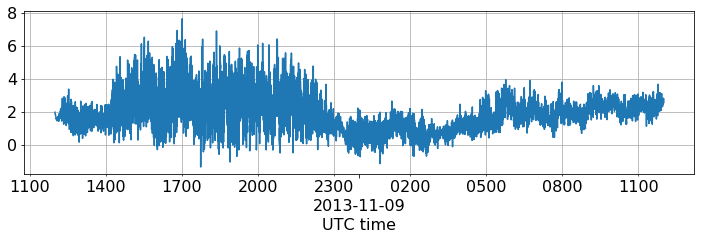

In [14]:
fig, ax = plot_timehistory_at_height(
    df,
    fields='u',
    heights = df.index.levels[1][0]
)

## 2. Data processing

### 2a. 10-min statistics

In [15]:
def calc_stats(df,offset='10min'):
    # calculate statistical quantities on unstacked 
    unstacked = df.unstack()
    stats = unstacked.resample(offset).mean().stack()
    # - calculate variances
    stats['uu'] = unstacked['u'].resample(offset).var().stack()
    stats['vv'] = unstacked['v'].resample(offset).var().stack()
    stats['ww'] = unstacked['w'].resample(offset).var().stack()
    # - calculate covariances
    stats['uv'] = covariance(unstacked['u'], unstacked['v'], offset, resample=True).stack()
    stats['vw'] = covariance(unstacked['v'], unstacked['w'], offset, resample=True).stack()
    stats['uw'] = covariance(unstacked['u'], unstacked['w'], offset, resample=True).stack()
    stats['thetaw'] = covariance(unstacked['theta'], unstacked['w'], offset, resample=True).stack()
    return stats

In [16]:
def calc_QOIs(df):
    # calculate derived quantities
    df['wspd'],df['wdir'] = calc_wind(df)
    df['u*'] = (df['uw']**2 + df['vw']**2)**0.25
    df['TKE'] = 0.5*(df['uu'] + df['vv'] + df['ww'])
    ang = np.arctan2(df['v'],df['u'])
    df['TI'] = df['uu']*np.cos(ang)**2 + 2*df['uv']*np.sin(ang)*np.cos(ang) + df['vv']*np.sin(ang)**2
    df['TI'] = np.sqrt(df['TI']) / df['wspd']

In [17]:
%time df_10min = calc_stats(df)
# CPU times: user 9.32 s, sys: 2.02 s, total: 11.3 s
# Wall time: 11.4 s

CPU times: user 9.32 s, sys: 2.02 s, total: 11.3 s
Wall time: 11.4 s


In [18]:
calc_QOIs(df_10min)

In [19]:
df_10min.head()

u         v         w       theta  \
datetime            height                                             
2013-11-08 12:00:00 5.001   1.680257  2.271912  0.001054  282.907679   
                    15.001  3.034235  4.340832  0.002532  284.015850   
                    25.001  3.990332  5.424120  0.000381  284.690796   
                    35.001  4.931860  6.362004 -0.008005  285.484187   
                    45.001  6.216764  7.330863 -0.004169  286.301082   

                                  uu        vv        ww        uv        vw  \
datetime            height                                                     
2013-11-08 12:00:00 5.001   0.014277  0.036897  0.000054  0.019851 -0.000330   
                    15.001  0.029048  0.011777  0.000895  0.008518  0.000772   
                    25.001  0.028712  0.021125  0.004479  0.008668 -0.002460   
                    35.001  0.077456  0.025837  0.009530  0.018822 -0.003934   
                    45.001  0.166550  0.029751  0.011219  0.038966 -0.002269   

                                  uw    thetaw      wspd        wdir  \
datetime            height                                             
2013-11-08 12:00:00 5.001  -0.000141 -0.000110  2.825748  216.485827   
                    15.001  0.000410 -0.000506  5.296169  214.953489   
                    25.001 -0.002907 -0.002395  6.733783  216.340590   
                    35.001 -0.008370 -0.001819  8.049742  217.783032   
                    45.001  0.000943 -0.003808  9.611956  220.298817   

                                  u*       TKE        TI  
datetime            height                                
2013-11-08 12:00:00 5.001   0.018928  0.025614  0.077436  
                    15.001  0.029568  0.020860  0.030119  
                    25.001  0.061711  0.027158  0.026592  
                    35.001  0.096170  0.056411  0.031290  
                    45.001  0.049571  0.103760  0.036844

In [20]:
%time df_10min.to_csv(output_tower0_10min)
# CPU times: user 740 ms, sys: 13.8 ms, total: 753 ms
# Wall time: 794 ms

CPU times: user 740 ms, sys: 13.8 ms, total: 753 ms
Wall time: 794 ms


### 2b. Turbulence spectra

Define some helper functions

In [21]:
def interpolate_to_heights(df,heights):
    # Unstack to single height index (= most time-consuming operation)
    unstacked = df.unstack(level='datetime')
    # Interpolate to specified heights
    f = interp1d(unstacked.index,unstacked,axis=0,fill_value='extrapolate')
    for hgt in heights:
        unstacked.loc[hgt] = f(hgt)
    # Restack and set index
    df_out = unstacked.loc[heights].stack().reset_index().set_index(['datetime','height']).sort_index()
    return df_out

In [22]:
def reindex_if_needed(df):
    dts = np.diff(df.index.get_level_values(0).unique())/pd.to_timedelta(1,'s')
    if not np.allclose(dts,dts[0]):
        # df is missing some timestamps, which will cause a problem when computing spectra.
        # therefore, we first reindex the dataframe
        start = df.index.levels[0][0]
        end   = df.index.levels[0][-1]
        new_index = pd.date_range(start,end,freq=pd.to_timedelta(dts[0],'s'),name='datetime')
        return df.unstack().reindex(new_index).interpolate(method='index').stack()
    else:
        return df

In [23]:
def calc_spectra(df,times,heights):
    dflist = []
    for tstart in times:
        for height in heights:
            spectra = power_spectral_density(df.xs(height,level='height'),
                                             tstart=pd.to_datetime(tstart),
                                             interval='1h',
                                             window_size='30min')
            spectra['datetime'] = pd.to_datetime(tstart)
            spectra['height'] = height
            dflist.append(spectra)
    df_spectra = pd.concat(dflist)
    return df_spectra.set_index(['datetime','height','frequency']).sort_index()

In [24]:
# Compute windspeed and direction
df['wspd'], df['wdir'] = calc_wind(df)

In [25]:
# Interpolate to desired heights
%time df_hgt = interpolate_to_heights(df,spectra_heights)
# CPU times: user 20.4 s, sys: 4.87 s, total: 25.3 s
# Wall time: 25.4 s

CPU times: user 20.4 s, sys: 4.87 s, total: 25.3 s
Wall time: 25.4 s


In [26]:
# Make sure data is equally spaced in time
%time df_hgt = reindex_if_needed(df_hgt)
# CPU times: user 380 ms, sys: 137 µs, total: 380 ms
# Wall time: 380 ms

CPU times: user 380 ms, sys: 137 µs, total: 380 ms
Wall time: 380 ms


In [27]:
# Compute spectra
%time df_spectra = calc_spectra(df_hgt,spectra_times,spectra_heights)
df_spectra.head()
# CPU times: user 2.67 s, sys: 1.92 ms, total: 2.67 s
# Wall time: 2.68 s

CPU times: user 2.67 s, sys: 1.92 ms, total: 2.67 s
Wall time: 2.68 s


u         v         w     theta  \
datetime            height frequency                                           
2013-11-08 12:00:00 10.0   0.000000   1.807164  0.928544  0.059158  2.017122   
                           0.000556   9.497117  4.976299  0.146140  7.253449   
                           0.001111   4.980287  5.072441  0.101288  3.373896   
                           0.001667   1.488720  2.431627  0.197119  0.893901   
                           0.002222   2.846409  4.900414  0.075537  1.452124   

                                           wspd        wdir  
datetime            height frequency                         
2013-11-08 12:00:00 10.0   0.000000    1.051998  507.278906  
                           0.000556   10.228055  999.585788  
                           0.001111    9.206182  182.199183  
                           0.001667    3.256823  174.137924  
                           0.002222    6.720440  266.852209

In [28]:
%time df_spectra.to_csv(output_tower0_spectra)
# CPU times: user 2.01 s, sys: 26.1 ms, total: 2.04 s
# Wall time: 2.13 s

CPU times: user 2.01 s, sys: 26.1 ms, total: 2.04 s
Wall time: 2.13 s


## 3. Reference data

### 3a. Load WRF reference data

NetCDF file with WRF data at the SWiFT site, generated in `wrf_to_sowfa.ipynb`

In [29]:
WRFdata = 'WRF_20131108-09.nc'

In [30]:
xa = xarray.open_dataset(WRFdata)

In [31]:
wrf = xa.to_dataframe()
wrf.head()

U10      V10          T2         TSK     UST  \
Time       height                                                      
2013-11-08 0.0     0.476012  4.92231  284.730592  282.509581  0.0001   
           5.0     0.476012  4.92231  284.730592  282.509581  0.0001   
           10.0    0.476012  4.92231  284.730592  282.509581  0.0001   
           15.0    0.476012  4.92231  284.730592  282.509581  0.0001   
           20.0    0.476012  4.92231  284.730592  282.509581  0.0001   

                           PSFC  HFX   LH  MUU  MUV  ...  RV_TEND  \
Time       height                                    ...            
2013-11-08 0.0     91081.063181  0.0  0.0  0.0  0.0  ...      NaN   
           5.0     91081.063181  0.0  0.0  0.0  0.0  ...      NaN   
           10.0    91081.063181  0.0  0.0  0.0  0.0  ...      NaN   
           15.0    91081.063181  0.0  0.0  0.0  0.0  ...      NaN   
           20.0    91081.063181  0.0  0.0  0.0  0.0  ...      NaN   

                   RV_TEND_ADV  RV_TEND_PGF  RV_TEND_COR  RV_TEND_PHYS  \
Time       height                                                        
2013-11-08 0.0             NaN          NaN          NaN           NaN   
           5.0             NaN          NaN          NaN           NaN   
           10.0            NaN          NaN          NaN           NaN   
           15.0            NaN          NaN          NaN           NaN   
           20.0            NaN          NaN          NaN           NaN   

                   T_TEND_ADV   wt   L0     thetaSK      theta2  
Time       height                                                
2013-11-08 0.0            NaN  0.0 -inf  290.149435  292.430509  
           5.0            NaN  0.0 -inf  290.149435  292.430509  
           10.0           NaN  0.0 -inf  290.149435  292.430509  
           15.0           NaN  0.0 -inf  290.149435  292.430509  
           20.0           NaN  0.0 -inf  290.149435  292.430509  

[5 rows x 30 columns]

In [32]:
wrf.columns

Index(['U10', 'V10', 'T2', 'TSK', 'UST', 'PSFC', 'HFX', 'LH', 'MUU', 'MUV',
       'MUT', 'U', 'V', 'W', 'theta', 'RU_TEND', 'RU_TEND_ADV', 'RU_TEND_PGF',
       'RU_TEND_COR', 'RU_TEND_PHYS', 'RV_TEND', 'RV_TEND_ADV', 'RV_TEND_PGF',
       'RV_TEND_COR', 'RV_TEND_PHYS', 'T_TEND_ADV', 'wt', 'L0', 'thetaSK',
       'theta2'],
      dtype='object')

In [33]:
# Convert to standard names
wrf.rename({'U':'u','V':'v','W':'w','UST':'u*'},
           axis='columns',inplace=True)

In [34]:
# Compute wind speed and wind direction
wrf['wspd'], wrf['wdir'] = calc_wind(wrf)

### 3b. Load TTU tower data

Datasets generated in `process_TTU_tower.ipynb` which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment)

In [35]:
towerdata_10min = 'TTU_tilt_corrected_20131108-09_10min.csv'
towerdata       = 'TTU_tilt_corrected_20131108-09.csv'

10-min statistics

In [36]:
tower_10min = pd.read_csv(towerdata_10min,parse_dates=True,index_col=['datetime','height'])
tower_10min.head()

RH        T          Ts           p       theta  \
datetime   height                                                        
2013-11-08 0.9     26.186  284.794  289.410000  908.547754  292.713920   
           2.4     25.810  284.932  290.979994  908.723508  292.839558   
           4.0     25.380  285.166  287.520000  908.215548  293.126923   
           10.1    25.264  285.298  287.250000  907.611414  293.318423   
           16.8    24.934  285.414  287.610000  907.307654  293.465778   

                       thetas         u         v         w      wspd  ...  \
datetime   height                                                      ...   
2013-11-08 0.9     297.458288 -0.138929  2.637817  0.074016  2.641473  ...   
           2.4     299.055399 -0.601111  2.783204  0.487330  2.847378  ...   
           4.0     295.546639  0.416792  4.043940  0.295800  4.065362  ...   
           10.1    295.325299 -0.276479  5.227110 -0.418065  5.234417  ...   
           16.8    295.723729  0.034364  5.908367 -0.173836  5.908467  ...   

                         vv        ww   uv   vw   uw   Tw  thetaw   u*  \
datetime   height                                                        
2013-11-08 0.9     0.015000  0.008343  0.0  0.0  0.0  0.0     0.0  0.0   
           2.4     0.165325  0.078520  0.0  0.0  0.0  0.0     0.0  0.0   
           4.0     0.269958  0.003119  0.0  0.0  0.0  0.0     0.0  0.0   
           10.1    0.027879  0.221537  0.0  0.0  0.0  0.0     0.0  0.0   
           16.8    0.054370  0.019302  0.0  0.0  0.0  0.0     0.0  0.0   

                        TKE        TI  
datetime   height                      
2013-11-08 0.9     0.012876  0.048324  
           2.4     0.289067  0.126433  
           4.0     0.141290  0.117591  
           10.1    0.127415  0.032939  
           16.8    0.041629  0.040432  

[5 rows x 22 columns]

In [37]:
tower_10min.columns

Index(['RH', 'T', 'Ts', 'p', 'theta', 'thetas', 'u', 'v', 'w', 'wspd', 'wdir',
       'uu', 'vv', 'ww', 'uv', 'vw', 'uw', 'Tw', 'thetaw', 'u*', 'TKE', 'TI'],
      dtype='object')

1-Hz data to compute spectra

In [38]:
tower = pd.read_csv(towerdata,parse_dates=True,index_col=['datetime','height'])
tower.head()

u         v         w          Ts        T      RH  \
datetime   height                                                              
2013-11-08 0.9    -0.138929  2.637817  0.074016  289.410000  284.794  26.186   
           2.4    -0.601111  2.783204  0.487330  290.979994  284.932  25.810   
           4.0     0.416792  4.043940  0.295800  287.520000  285.166  25.380   
           10.1   -0.276479  5.227110 -0.418065  287.250000  285.298  25.264   
           16.8    0.034364  5.908367 -0.173836  287.610000  285.414  24.934   

                            p  
datetime   height              
2013-11-08 0.9     908.547754  
           2.4     908.723508  
           4.0     908.215548  
           10.1    907.611414  
           16.8    907.307654

In [39]:
# Calculate some QoI
tower['wspd'], tower['wdir'] = calc_wind(tower)
tower['theta'] = theta(tower['Ts'],tower['p'])

In [40]:
%time tower_hgt = interpolate_to_heights(tower,spectra_heights)
# CPU times: user 4.51 s, sys: 422 ms, total: 4.93 s
# Wall time: 4.94 s

CPU times: user 4.51 s, sys: 422 ms, total: 4.93 s
Wall time: 4.94 s


In [41]:
tower_hgt = reindex_if_needed(tower_hgt)

In [42]:
%time tower_spectra = calc_spectra(tower_hgt,spectra_times,spectra_heights)
tower_spectra.head()
# CPU times: user 3.22 s, sys: 0 ns, total: 3.22 s
# Wall time: 3.23 s

CPU times: user 3.22 s, sys: 0 ns, total: 3.22 s
Wall time: 3.23 s


u          v         w  \
datetime            height frequency                                   
2013-11-08 12:00:00 10.0   0.000000    2.743016  20.591836  0.026654   
                           0.000556   10.681622  53.310095  0.031015   
                           0.001111   26.673723  22.982941  0.097595   
                           0.001667   13.428832   2.564696  0.158012   
                           0.002222    3.756646   1.509971  0.039179   

                                            Ts         T         RH         p  \
datetime            height frequency                                            
2013-11-08 12:00:00 10.0   0.000000   3.161929  4.127919  13.464242  0.324514   
                           0.000556   5.856587  7.975296  61.523613  0.713716   
                           0.001111   4.453153  3.333684  53.021902  0.355329   
                           0.001667   7.935680  5.799624  49.366405  0.597527   
                           0.002222   2.414650  1.525970  14.103281  0.240249   

                                           wspd         wdir     theta  
datetime            height frequency                                    
2013-11-08 12:00:00 10.0   0.000000   14.595468  2086.893012  3.315482  
                           0.000556   34.581021  8269.856925  6.148264  
                           0.001111   13.373813  9661.112345  4.647388  
                           0.001667    3.628736  2802.012137  8.364211  
                           0.002222    3.775898   507.479380  2.513611

### 3c. Load TTU radar data

Dataset generated in `process_TTU_radar.ipynb` which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment)

In [43]:
radardata = 'TTU_obs_QC_20131108.csv'

In [44]:
radar = pd.read_csv(radardata,parse_dates=True,index_col=['datetime','height'])
radar.head()

t_index  scan_type      wspd        wdir  \
datetime            height                                             
2013-11-08 12:00:00 0.9         0.0       -1.0  1.225746  219.005685   
                    2.4         0.0       -1.0  1.772110  225.353123   
                    4.0         0.0       -1.0  2.046332  229.267605   
                    10.1        0.0       -1.0  2.979477  233.780026   
                    16.8        0.0       -1.0  3.944645  239.036134   

                                   u         v  
datetime            height                      
2013-11-08 12:00:00 0.9     0.771481  0.952507  
                    2.4     1.260770  1.245325  
                    4.0     1.550640  1.335287  
                    10.1    2.403706  1.760534  
                    16.8    3.382502  2.029510

In [45]:
radar_scan0 = radar.loc[radar['scan_type']==0].copy()
radar_scan1 = radar.loc[radar['scan_type']==1].copy()

## 4. Plot virtual tower data

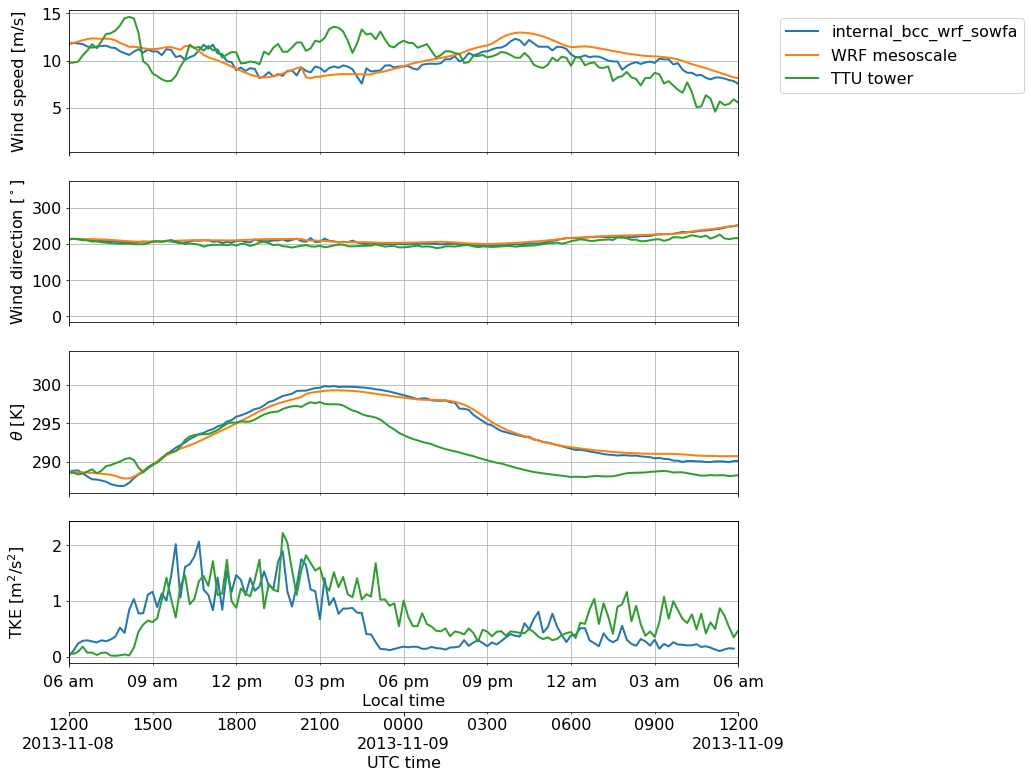

In [46]:
fig,ax,ax2 = plot_timehistory_at_height(
    datasets={simname:df_10min,'WRF mesoscale':wrf,'TTU tower':tower_10min},
    fields = ['wspd','wdir','theta','TKE'],
    heights = 80,
    # Specify time limits
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # plot local time
    plot_local_time=True,
    local_time_offset=-6,
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)

# Adjust xaxis tick locations
ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

In [47]:
df_1h = df_10min.unstack().resample('1h').mean().stack()
tower_1h = tower_10min.unstack().resample('1h').mean().stack()
radar_scan0_1h = radar_scan0.unstack().resample('1h').mean().stack()
radar_scan1_1h = radar_scan1.unstack().resample('1h').mean().stack()
wrf_1h = wrf.unstack().resample('1h').mean().stack()

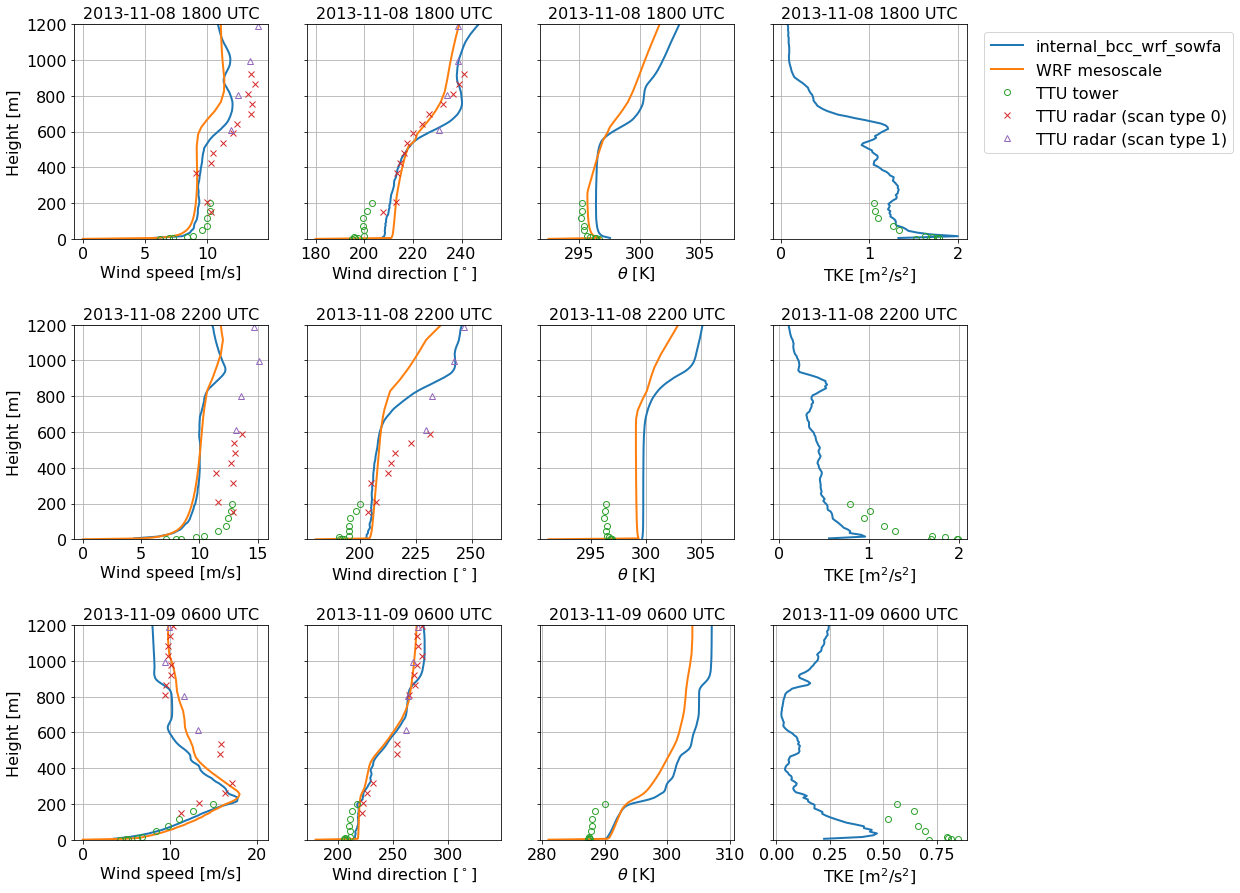

In [48]:
fig,ax = plot_profile(
    datasets={simname:df_1h,
              'WRF mesoscale':wrf_1h,
              'TTU tower':tower_1h,
              'TTU radar (scan type 0)':radar_scan0_1h,
              'TTU radar (scan type 1)':radar_scan1_1h},
    fields=['wspd','wdir','theta','TKE'],
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    # Specify height limits
    heightlimits=(0,1200),
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    # Change field order to have different fields correspond to different columns instead of rows
    fieldorder='F',
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6},
                   'TTU radar (scan type 0)':{'linestyle':'','marker':'x','mfc':'none','markersize':6},
                   'TTU radar (scan type 1)':{'linestyle':'','marker':'^','mfc':'none','markersize':6}
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
)

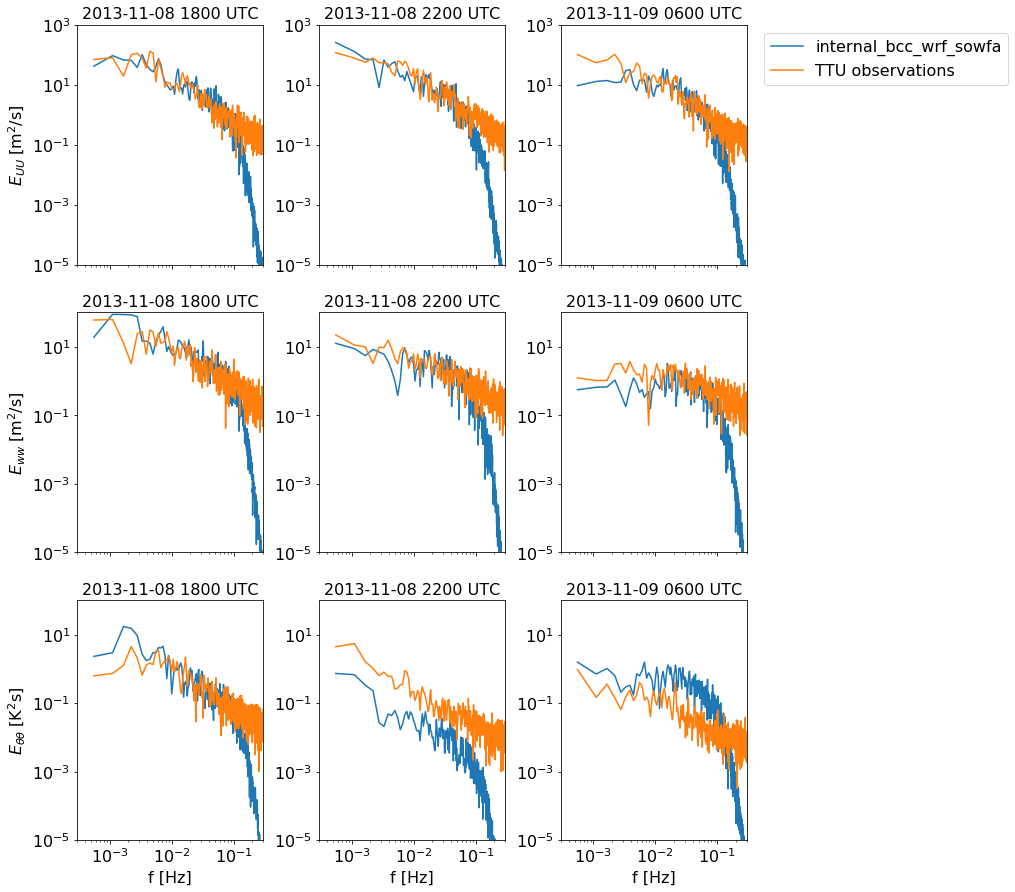

In [49]:
fig,ax = plot_spectrum(
    datasets={simname:df_spectra,'TTU observations':tower_spectra},
    height=80,
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    fields=['wspd','w','theta'],
    freqlimits=(0.0003,0.3),
    fieldlimits={'wspd':(1.0e-5,1.0e3),'w':(1.0e-5,1.0e2),'theta':(1.0e-5,1.0e2)},
)

# Part 2: Load, process, average and save all virtual tower data

In [50]:
%%time
df_10min = []
df_spectra = []
for towerID, tpath in enumerate(tpathlist):
    print('Reading '+tpath)
    try:
        # 1. Read tower
        dfi = reader(tpath)
        
        # 2. Calculate statistics
        dfi_10min = calc_stats(dfi)
        dfi_10min['towerID'] = towerID
        
        # 3. Calculate spectra
        # - compute wspd and wdir so that corresponding spectra are calculated as well
        dfi['wspd'],dfi['wdir'] = calc_wind(dfi)
        # - interpolate to specific heights
        dfi_hgt = interpolate_to_heights(dfi,spectra_heights)
        # - reindex if some timestamps are missing
        dfi_hgt = reindex_if_needed(dfi_hgt)
        # - calculate spectra at specific times
        dfi_spectra = calc_spectra(dfi_hgt,spectra_times,spectra_heights)
        dfi_spectra['towerID'] = towerID
    except (IOError, UnicodeDecodeError, AssertionError, ValueError) as err:
        print(err,'while reading',tpath)
    
    # Append to list
    df_10min.append(dfi_10min)
    df_spectra.append(dfi_spectra)
    
df_10min = pd.concat(df_10min)
df_10min.set_index('towerID',append=True,inplace=True)

df_spectra = pd.concat(df_spectra)
df_spectra.set_index('towerID',append=True,inplace=True)

# CPU times: user 20min 3s, sys: 2min 35s, total: 22min 39s
# Wall time: 22min 53s

Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe1
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe2
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe3
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe4
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe5
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe6
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe7
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe8
Reading /scratch/dallaert/SWIFTcomparison/run.internal.bcc.wrf/postProcessing/probe9
CPU times: user 20min 3s, sys: 2min 35s, total: 22min 39s
Wall time: 22min 53s


In [51]:
df_10min.head(n=10)

u          v         w       theta  \
datetime            height towerID                                              
2013-11-08 12:00:00 5.001  0        1.680257   2.271912  0.001054  282.907679   
                    15.001 0        3.034235   4.340832  0.002532  284.015850   
                    25.001 0        3.990332   5.424120  0.000381  284.690796   
                    35.001 0        4.931860   6.362004 -0.008005  285.484187   
                    45.001 0        6.216764   7.330863 -0.004169  286.301082   
                    55.001 0        5.734964   7.989761  0.011908  287.220448   
                    65.001 0        6.241696   8.433769  0.001220  287.895892   
                    75.001 0        6.743363   9.356230 -0.007434  288.428609   
                    85.001 0        6.772118  10.055776 -0.001811  288.868600   
                    95.001 0        7.152389  10.738132  0.002970  289.253524   

                                          uu        vv        ww        uv  \
datetime            height towerID                                           
2013-11-08 12:00:00 5.001  0        0.014277  0.036897  0.000054  0.019851   
                    15.001 0        0.029048  0.011777  0.000895  0.008518   
                    25.001 0        0.028712  0.021125  0.004479  0.008668   
                    35.001 0        0.077456  0.025837  0.009530  0.018822   
                    45.001 0        0.166550  0.029751  0.011219  0.038966   
                    55.001 0        0.035899  0.014398  0.010549 -0.002272   
                    65.001 0        0.006710  0.014114  0.001503  0.004525   
                    75.001 0        0.009618  0.003061  0.002325  0.003119   
                    85.001 0        0.002186  0.009394  0.004689  0.002121   
                    95.001 0        0.038488  0.024174  0.001699  0.028611   

                                          vw        uw    thetaw  
datetime            height towerID                                
2013-11-08 12:00:00 5.001  0       -0.000330 -0.000141 -0.000110  
                    15.001 0        0.000772  0.000410 -0.000506  
                    25.001 0       -0.002460 -0.002907 -0.002395  
                    35.001 0       -0.003934 -0.008370 -0.001819  
                    45.001 0       -0.002269  0.000943 -0.003808  
                    55.001 0        0.000157 -0.001609  0.001026  
                    65.001 0       -0.000538 -0.000533  0.000789  
                    75.001 0       -0.000017 -0.000017 -0.001129  
                    85.001 0       -0.000058  0.000524 -0.000218  
                    95.001 0        0.000015  0.000147  0.000229

In [52]:
df_spectra.head(n=10)

u          v         w  \
datetime            height frequency towerID                                  
2013-11-08 12:00:00 10.0   0.000000  0        1.807164   0.928544  0.059158   
                           0.000556  0        9.497117   4.976299  0.146140   
                           0.001111  0        4.980287   5.072441  0.101288   
                           0.001667  0        1.488720   2.431627  0.197119   
                           0.002222  0        2.846409   4.900414  0.075537   
                           0.002778  0        5.973215   7.587177  0.108439   
                           0.003333  0        6.079305   6.402854  0.329724   
                           0.003889  0        6.141630  10.625006  0.155563   
                           0.004444  0        6.773565  14.277783  0.271647   
                           0.005000  0        6.027575  15.005357  0.655824   

                                                 theta       wspd        wdir  
datetime            height frequency towerID                                   
2013-11-08 12:00:00 10.0   0.000000  0        2.017122   1.051998  507.278906  
                           0.000556  0        7.253449  10.228055  999.585788  
                           0.001111  0        3.373896   9.206182  182.199183  
                           0.001667  0        0.893901   3.256823  174.137924  
                           0.002222  0        1.452124   6.720440  266.852209  
                           0.002778  0        1.744971  12.610439  190.595120  
                           0.003333  0        0.845908  10.638430  200.012832  
                           0.003889  0        0.721974  15.804093  216.296464  
                           0.004444  0        1.233867  20.162291  298.851019  
                           0.005000  0        0.882342  19.610816  355.845671

Average over all the towers

In [53]:
df_10min = df_10min.unstack(level=['datetime','height']).mean(axis=0).unstack(level=0)

In [54]:
%time df_10min.to_csv(output_all_10min)
# CPU times: user 537 ms, sys: 6.36 ms, total: 543 ms
# Wall time: 589 ms

CPU times: user 537 ms, sys: 6.36 ms, total: 543 ms
Wall time: 589 ms


In [55]:
df_spectra = df_spectra.unstack(level=['datetime','height','frequency']).mean(axis=0).unstack(level=0)

In [56]:
%time df_spectra.to_csv(output_all_spectra)
# CPU times: user 2.04 s, sys: 25 ms, total: 2.07 s
# Wall time: 2.14 s

CPU times: user 2.04 s, sys: 25 ms, total: 2.07 s
Wall time: 2.14 s
